In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from warnings import filterwarnings

filterwarnings(action="ignore")
%matplotlib notebook

In [2]:
class ClassificationSummary:
    
    def __init__(self, y_true: np.array ,y_pred: np.array):
        
        self.__y_true: array = y_true
        self.__y_pred: array = y_pred
        self.__confusion_matrix: np.ndarray
        self.__sensitivity: float
        self.__specificity: float
        self.__accuracy: float
        self.missclassification_error: float
        self.__recall_score: float
        self.__precision_score: float
        self.__summary_data()
    
    @property
    def y_true(self):
        return self.__y_true
    
    @property
    def y_pred(self):
        return self.__y_pred
    
    @property
    def confusion_matrix(self):
        return self.__confusion_matrix
    
    @property
    def sensitivity(self):
        return self.__sensitivity
    
    @property
    def specificity(self):
        return self.__specificity
    
    @property
    def accuracy(self):
        return self.__accuracy

    @property
    def recall_score(self):
        return self.__recall_score
    
    @property
    def precision_score(self):
        return self.__precision_score
    
    @property
    def missclassification_error(self):
        return self.__missclassification_error
    
    def __summary_data(self):
        self.__confusion_matrix = sklearn.metrics.confusion_matrix(self.__y_true, self.__y_pred)
        tn, fp, fn, tp = self.__confusion_matrix.ravel()
        self.__sensitivity: float = tp / (tp + fn)
        self.__specificity: float = tn / (tn + fp)
        self.__accuracy: float = (tn + tp) / (tn + fp + fn + tp)
        self.__missclassification_error: float = 1 - self.__accuracy
        self.__recall_score = sklearn.metrics.recall_score(self.__y_true, self.__y_pred)
        self.__precision_score = sklearn.metrics.precision_score(self.__y_true, self.__y_pred)
            
    def __repr__(self):

        r2 = lambda x: round(x * 100,2)
        
        return(
                "Confusion Matrix:\n{}".format(self.__confusion_matrix)
               +"\n"
               +"Accuracy: {}%".format(r2(self.__accuracy))
               +"\n"
               +"Missclassification Error: {}%".format(r2(self.__missclassification_error))
               +"\n"
               +"Sensitivity: {}%".format(r2(self.__sensitivity))
               +"\n"
               +"Specificity: {}%".format(r2(self.__specificity))
               +"\n"
               +"Recall Score: {}%".format(r2(self.__recall_score))
               +"\n"
               +"Precision Score: {}%".format(r2(self.__precision_score))
              )

In [3]:
# Adding Backwards ellimination to Logit

class Logit2(sm.Logit):
    
    def __init__(self,y,X,sl=0.05):
        super(Logit2, self).__init__(y,X,sl=0.05)
        self.X = X
        self.y = y
        self.sl = sl
        self.sigCols = str
        
    def backward_elimination(self):
        
        colList = self.X.columns
    
        while len(colList) > 0:
            model = sm.Logit(self.y,self.X[colList])
            result = model.fit()
            largest_pvalue = round(result.pvalues,3).nlargest(1)
            if largest_pvalue[0] < self.sl:
                self.sigCols = colList
                return result
                break
            else:
                colList = colList.drop(largest_pvalue.index)

In [4]:
r2 = lambda x: round(x * 100,2)

In [5]:
bc_df = pd.read_csv("breast_cancer.csv")

In [6]:
bc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


In [7]:
# Replace values 2,4 with boolean 0,1 values
bc_df.Class.replace(to_replace=[2,4], value=[0,1], inplace=True)

In [8]:
# drop columns that provide no use
bc_df.drop(columns=["Sample code number"],inplace=True)

In [9]:
bc_df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


<IPython.core.display.Javascript object>


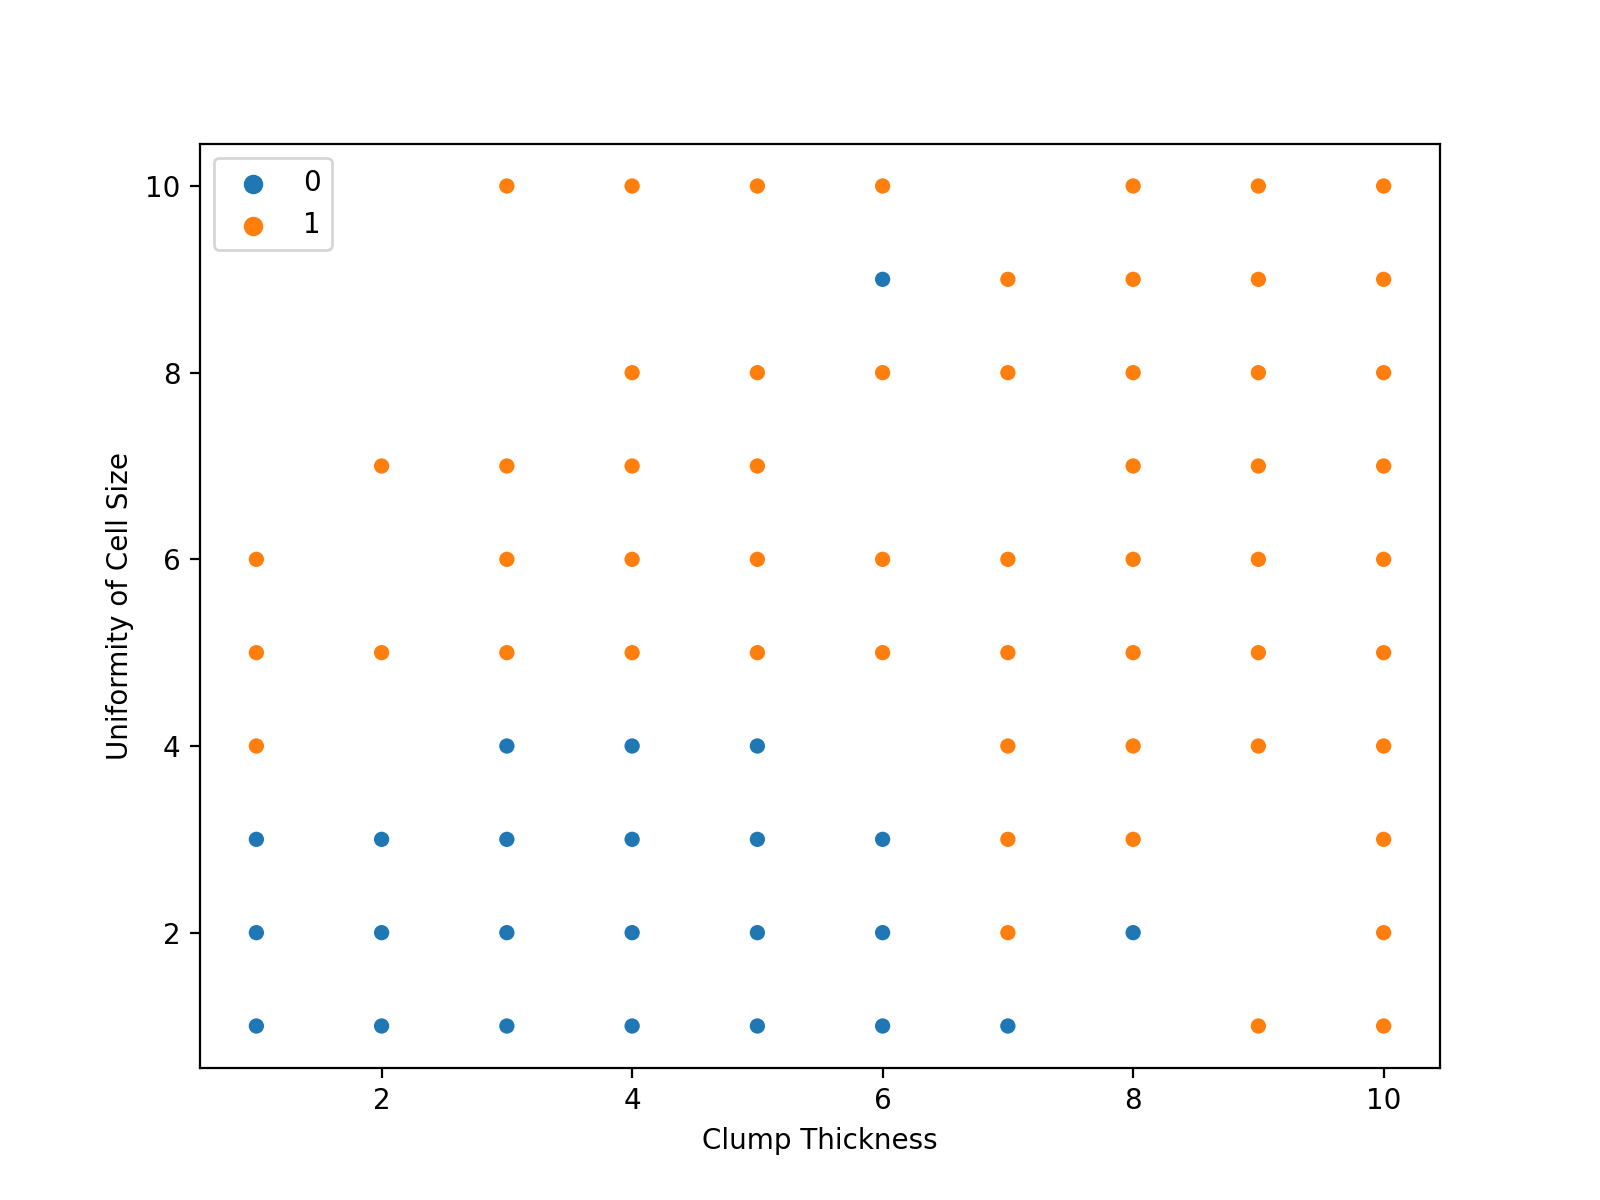

In [10]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=bc_df,x="Clump Thickness", y="Uniformity of Cell Size", hue="Class")
plt.legend()
plt.show()

In [11]:
X = bc_df.iloc[:,1:-1]
y = bc_df.iloc[:,-1].values

In [12]:
results = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.410611
         Iterations 8


In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  683
Model:                          Logit   Df Residuals:                      675
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:                  0.3658
Time:                        17:07:37   Log-Likelihood:                -280.45
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                 5.884e-66
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Uniformity of Cell Size         0.9512      0.127      7.474      0.000       0.702       1.201
Uniformity of Cell Shape        0.0531      0.107      0.495      0.621      -0.157       0.264
Marginal Adhesion               0.1042      0.073      1.431      0.153      -0.039       0.247
Single Epithelial Cell Size    -0.8806      0.100     -8.807      0.000      -1.077      -0.685
Bare Nuclei                     0.4880      0.063      7.758      0.000       0.365       0.611
Bland Chromatin                -0.6540      0.088     -7.401      0.000      -0.827      -0.481
Normal Nucleoli                 0.3567      0.071      5.006      0.000       0.217       0.496
Mitoses                        -0.3104      0.085     -3.634      0.000      -0.478      -0.143
===============================================================================================
"""

In [14]:
logReg = Logit2(y,X)

In [15]:
logReg.backward_elimination().summary()

Optimization terminated successfully.
         Current function value: 0.410611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.410792
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.412325
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  683
Model:                          Logit   Df Residuals:                      677
Method:                           MLE   Df Model:                            5
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:                  0.3631
Time:                        17:07:37   Log-Likelihood:                -281.62
converged:                       True   LL-Null:                       -442.18
Covariance Type:            nonrobust   LLR p-value:                 2.882e-67
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Uniformity of Cell Size         1.0112      0.106      9.512      0.000       0.803       1.220
Single Epithelial Cell Size    -0.8629      0.099     -8.733      0.000      -1.057      -0.669
Bare Nuclei                     0.5060      0.061      8.232      0.000       0.386       0.626
Bland Chromatin                -0.6256      0.086     -7.305      0.000      -0.793      -0.458
Normal Nucleoli                 0.3581      0.070      5.081      0.000       0.220       0.496
Mitoses                        -0.2895      0.084     -3.442      0.001      -0.454      -0.125
===============================================================================================
"""

In [16]:
logReg.sigCols

Index(['Uniformity of Cell Size', 'Single Epithelial Cell Size', 'Bare Nuclei',
       'Bland Chromatin', 'Normal Nucleoli', 'Mitoses'],
      dtype='object')

In [17]:
bc_df = bc_df[['Clump Thickness', 'Uniformity of Cell Size',
               'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
               'Normal Nucleoli', 'Mitoses','Class']]

In [18]:
X = bc_df.iloc[:,1:-1].values
y = bc_df.iloc[:,-1].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [20]:
lgr = LogisticRegression()

In [21]:
lgr.fit(X_train,y_train)

LogisticRegression()

In [22]:
ypred = lgr.predict(X_test)

In [23]:
cs1 = ClassificationSummary(y_test,ypred)
cs1

Confusion Matrix:
[[102   5]
 [  9  55]]
Accuracy: 91.81%
Missclassification Error: 8.19%
Sensitivity: 85.94%
Specificity: 95.33%
Recall Score: 85.94%
Precision Score: 91.67%

# Cross Validation Logistic Regression

In [24]:
lgr = LogisticRegression()

In [25]:
cvs = cross_val_score(lgr,X_train,y_train,cv=10)

In [26]:
ma_cv = r2(cvs.mean())
ma_cv_std = r2(cvs.std())

In [27]:
print("Model Accuracy 10 Fold Cross Validation: {}%".format(ma_cv) 
      + "\n"
      + "Model Accuracy Standard Deviation: {:.2f}%".format(ma_cv_std))

Model Accuracy 10 Fold Cross Validation: 97.07%
Model Accuracy Standard Deviation: 2.64%


# Random Forests

In [28]:
X = bc_df.iloc[:,1:-1].values
y = bc_df.iloc[:,-1].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=9)

In [30]:
rf_classifier = RandomForestClassifier(n_estimators=100
                                       ,criterion="entropy"
                                      ,random_state=9)

In [31]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=9)

In [32]:
ypred = rf_classifier.predict(X_test)

In [33]:
cm = confusion_matrix(y_test, ypred)
cm

array([[84,  0],
       [ 1, 52]])

In [34]:
tn,fp,fn,tp = cm.ravel()

In [35]:
sense = tp / (tp+fn) * 100

print("Sensitivity {:.2f}%".format(sense))

Sensitivity 98.11%


In [36]:
spec = tn / (tn + fp) * 100

print("Specificity {:.2f}%".format(spec))

Specificity 100.00%


In [37]:
ACC = r2(accuracy_score(y_test,ypred))

In [38]:
print("Random Forest Model ACC: {}%".format(ACC))

Random Forest Model ACC: 99.27%


In [39]:
c2 = ClassificationSummary(y_test, ypred)
c2

Confusion Matrix:
[[84  0]
 [ 1 52]]
Accuracy: 99.27%
Missclassification Error: 0.73%
Sensitivity: 98.11%
Specificity: 100.0%
Recall Score: 98.11%
Precision Score: 100.0%

# Cross Validation Random Forest

In [40]:
rf_classifier = RandomForestClassifier(n_estimators=100
                                       ,criterion="entropy"
                                      ,random_state=9)

In [41]:
ACC = r2(cross_val_score(rf_classifier,X,y).mean())

In [42]:
print("CV - Random Forest ACC: {}%".format(ACC))

CV - Random Forest ACC: 95.91%


In [43]:
EER = r2(1 - cross_val_score(rf_classifier,X,y).mean())

In [44]:
print("Missclassification Error: {}%".format(EER))

Missclassification Error: 4.09%


# Support Vector Machine

In [45]:
sc = StandardScaler()

In [46]:
svm_classifier = SVC( C=4.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    random_state=9)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=9)

In [48]:
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [49]:
svm_classifier.fit(X_train,y_train)

SVC(C=4.0, random_state=9)

In [50]:
ypred = svm_classifier.predict(X_test)

In [51]:
c3 = ClassificationSummary(y_test, ypred)
c3

Confusion Matrix:
[[84  0]
 [ 3 50]]
Accuracy: 97.81%
Missclassification Error: 2.19%
Sensitivity: 94.34%
Specificity: 100.0%
Recall Score: 94.34%
Precision Score: 100.0%

# Support Vector Machine - Cross Validation

In [52]:
svm_classifier = SVC( C=4.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    random_state=9)

In [53]:
ACC = r2(cross_val_score(svm_classifier,X_train,y_train).mean())

In [54]:
print("SVM - Cross Validation: {}%".format(ACC))

SVM - Cross Validation: 95.24%


In [55]:
EER = r2(1 - cross_val_score(svm_classifier,X_train,y_train).mean())

In [56]:
print("Missclassification Error: {}%".format(EER))

Missclassification Error: 4.76%


# Gaussian Niave Bayes

In [57]:
gnb_classifier = GaussianNB()

In [58]:
sc = StandardScaler()

In [59]:
X = bc_df.iloc[:,:-1].values
y = bc_df.iloc[:,-1].values

In [60]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=9)

In [61]:
gnb_classifier.fit(X_train, y_train)

GaussianNB()

In [62]:
ypred = gnb_classifier.predict(X_test)

In [63]:
cs4 = ClassificationSummary(y_test,ypred)

In [64]:
cs4

Confusion Matrix:
[[104   1]
 [  1  65]]
Accuracy: 98.83%
Missclassification Error: 1.17%
Sensitivity: 98.48%
Specificity: 99.05%
Recall Score: 98.48%
Precision Score: 98.48%

# Gaussian Naive Bayes - Cross Validation

In [65]:
gnb_classifier2 = GaussianNB()

In [66]:
cv = cross_val_score(gnb_classifier2,X_train,y_train)

In [67]:
ACC = cv.mean()

In [68]:
EER = 1 - ACC

In [69]:
EER

0.04494574528840656

In [70]:
print("GNB - Cross Validation: {}%".format(r2(ACC)))

GNB - Cross Validation: 95.51%


In [71]:
print("GNB - Cross Validation - Missclassification Error: {}%".format(r2(EER)))

GNB - Cross Validation - Missclassification Error: 4.49%


# Bernoulli Naive Bayes

In [72]:
bnb_classifier = BernoulliNB()

In [73]:
bnb_classifier.fit(X_train,y_train)

BernoulliNB()

In [74]:
ypred = bnb_classifier.predict(X_test)

In [75]:
cs5 = ClassificationSummary(y_test,ypred)

In [76]:
cs5

Confusion Matrix:
[[105   0]
 [ 66   0]]
Accuracy: 61.4%
Missclassification Error: 38.6%
Sensitivity: 0.0%
Specificity: 100.0%
Recall Score: 0.0%
Precision Score: 0.0%